# 激活函数

我们一直着眼于网络模型的线性回归部分，而忽略了激活函数部分。

理论上，如果只是线性回归的话，无论多少层的网络模型仍然还是线性变换，并不会和单层网络模型有本质的差别。这也正是我们在上一个章节观察到的现象。

要让神经网络真正强大，必须引入**非线性**（Nonlinear）。这就是**激活函数**（Activation Function）可以起到的作用。

<div style="border-left: 4px solid #4CAF50; background:#f9f9f9; padding:10px; margin:10px 0;">
<strong>💡 通用近似定理：</strong> 数学证明，一个包含至少一个隐藏层和非线性激活函数的网络模型，可以以任意精度逼近任何连续函数。
</div>

隐藏层后面使用激活函数，可以使网络模型不再局限在线性模型，从而能够学习到输入与输出之间更复杂的关系。

In [1]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(99)

## 数据集

### 训练数据：特征、标签

In [2]:
train_features = np.array([[22.5, 72.0],
                           [31.4, 45.0],
                           [19.8, 85.0],
                           [27.6, 63]])
train_labels = np.array([[95],
                        [210],
                        [70],
                        [155]])

### 测试数据：特征、标签

In [3]:
test_features = np.array([[28.1, 58.0]])
test_labels = np.array([[165]])

## 模型

### 参数：隐藏层权重、偏置

In [4]:
hidden_weight = np.random.rand(4, 2) / 2
hidden_bias = np.random.rand(4)

### 参数：输出层权重、偏置

In [5]:
output_weight = np.random.rand(1, 4) / 4
output_bias = np.random.rand(1)

### 推理函数

In [6]:
def forward(x, w, b):
    return x @ w.T + b

### ReLU 激活函数

**线性整流函数**（Rectified Linear Unit）ReLU 是目前最常用的**隐藏层激活函数**。它的逻辑非常简单：负数归零。这是它的公式：

$$
ReLU = \max(0, x)
$$

ReLU 激活函数优点非常明显：

* 计算高效，仅需阈值操作；
* 过滤掉所有负数。可以理解为过滤掉所有不重要的信息，或者噪音；
* 所有正数保持不变，在正数区间的导数恒为 1 。因此不会减弱有效信息，导致梯度消失。这对于训练深层网络至关重要。

In [7]:
def relu(x):
    return np.maximum(0, x)

我们看一下 ReLU 激活函数的效果：

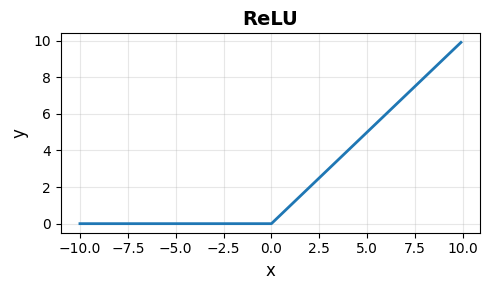

In [8]:
plt.figure(figsize=(5, 3))
x_range = np.arange(-10, 10, 0.1)
plt.plot(x_range, [relu(x) for x in x_range], linewidth=2)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('ReLU', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 损失函数（均方误差）

In [9]:
def mse_loss(p, y):
    return np.mean(np.square(y - p))

### 梯度函数

In [10]:
def gradient(p, y):
    return - 2 * (y - p) / len(y)

### 反向函数

In [11]:
def backward(x, d, w, b, lr):
    w -= d.T @ x * lr
    b -= np.sum(d, axis=0) * lr
    return w, b

### 梯度反向函数

In [12]:
def gradient_backward(d, w):
    return d @ w

### ReLU 反向函数

随着 ReLU 激活函数加入前向传播链路，梯度计算的过程中也需要加入 ReLU 反向函数，即 ReLU 激活函数的导数：

$$
\frac{dReLU}{dx} =
\begin{cases}
1 & \text{if } x > 0 \\
0 & \text{if } x \leq 0
\end{cases}
$$

In [13]:
def relu_backward(p, d):
    return (p > 0) * d

## 训练

### 超参数：学习率

In [14]:
LEARNING_RATE = 0.00001

### 超参数：批大小

In [15]:
BATCH_SIZE = 2

### 超参数：轮数

In [16]:
EPOCHS = 1000

### 迭代

数据在前向传播的过程中经过的所有计算步骤（包括激活函数），在梯度计算的过程中都需要以相反的次序，依次经过对应的反向函数。

1. **前向传播链路**：ReLU 激活函数在隐藏层前向传播的最后，相当于消除中间值的噪音（负数）。目的在于强化向下一层传播的信号。

```{figure} images/layer-relu-forward.png
:align: center
:width: 520px
```

* $x$：特征值；
* $w_1, b_1$：隐藏层权重和偏置；
* $h$：中间值；
* $w_2, b_2$：输出层权重和偏置；
* $p$：预测值。

2. **梯度计算链路**：ReLU 反向函数在隐藏层梯度计算之后，相当于过滤掉所有中间值噪音（负数）的梯度。目的在于终止这些噪音的训练。

```{figure} images/layer-relu-gradient.png
:align: center
:width: 600px
```

* $p$：预测值；
* $y$：标签值；
* $d_2$：输出层误差项；
* $w_2$：输出层权重；
* $h$：中间值；
* $d_1$：隐藏层误差项。

3. **反向传播链路**：激活函数不影响反向传播链路。

```{figure} images/layer-backward.png
:align: center
:width: 240px
```

* $d_2$：第二层误差项；
* $h$：中间值；
* $w_2, b_2$：第二层权重和偏置；
* $d_1$：第一层误差项；
* $x$：特征值；
* $w_1, b_1$：第一层权重和偏置。

现在，让我们把 ReLU 激活函数用到隐藏层之后，看看会有什么样的效果。

同时，也要记得在梯度计算的合适位置使用 ReLU 反向函数。

<div style="border-left: 4px solid #4CAF50; background:#f9f9f9; padding:10px; margin:10px 0;">
<strong>💡 提示：</strong> 通常在数值回归类型的模型中，输出层后面不需要激活函数。后续我们会看到，在分类模型中，输出层后面也会使用激活函数来辅助决策。
</div>

In [17]:
for epoch in range(EPOCHS):
    for i in range(0, len(train_features), BATCH_SIZE):
        features = train_features[i: i + BATCH_SIZE]
        labels = train_labels[i: i + BATCH_SIZE]

        # 隐藏层前向传播之后，使用 ReLU 激活函数
        hidden = relu(forward(features, hidden_weight, hidden_bias))
        # 输出层前向传播
        predictions = forward(hidden, output_weight, output_bias)

        # 输出层梯度计算
        output_delta = gradient(predictions, labels)
        # 隐藏层梯度计算之后，使用ReLU反向函数
        hidden_delta = relu_backward(hidden, gradient_backward(output_delta, output_weight))

        # 输出层反向传播
        output_weight, output_bias = backward(hidden, output_delta, output_weight, output_bias, LEARNING_RATE)
        # 隐藏层反向传播
        hidden_weight, hidden_bias = backward(features, hidden_delta, hidden_weight, hidden_bias, LEARNING_RATE)

print(f"hidden weight: {hidden_weight}")
print(f"hidden bias: {hidden_bias}")
print(f"output weight: {output_weight}")
print(f"output bias: {output_bias}")

hidden weight: [[ 1.44939484 -0.1488531 ]
 [ 1.43714974 -0.44943929]
 [ 2.01951138 -0.21496696]
 [ 0.69351093 -0.14538266]]
hidden bias: [1.01025119 0.02441728 0.79885347 0.75650847]
output weight: [[1.39916537 1.43560331 1.96797648 0.69705886]]
output bias: [1.00887392]


## 验证

### 推理

In [18]:
hidden = relu(forward(test_features, hidden_weight, hidden_bias))
predictions = forward(hidden, output_weight, output_bias)
print(f'predictions: {predictions}')

predictions: [[164.86381116]]


### 评估

In [19]:
loss = mse_loss(predictions, test_labels)
print(f'loss: {loss}')

loss: 0.018547399366677222


神奇的效果！

在上一个章节里，我们观察到两层网络模型虽然可行，但是并没有表现得比单层网络模型更出色，甚至有所减弱。

但是在我们使用了隐藏层激活函数后，效果大增到损失值几乎为 0 的程度。

这表明引入非线性激活函数后，模型具备了更强的表达能力，能够很好地拟合训练数据，并在测试样本上给出合理预测。

## 结束语

到此为止，我们从零开始，逐步构建了一个包括隐藏层和激活函数的多层神经网络模型。

在这个过程中，我们了解了神经网络的基本构成和工作原理。但是也意识到，随着网络层数的增加（隐藏层、激活函数），模型的复杂度也大幅增加，特别是在梯度计算和反向传播的过程中。

下一部分，我们将再次从零开始，构建我们自己的神经网络模型训练框架，实现前向传播、梯度计算和反向传播的自动化，降低神经网络的实现难度，让我们能够专注于模型设计和应用。